In [7]:
# Импортируем все необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import(
    train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import(
    OneHotEncoder, StandardScaler, MinMaxScaler)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from time import time
import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка данных
#### 1.1 Загрузка данных и изучение общей информации

In [8]:
try:
    autos = pd.read_csv("https://code.s3.yandex.net/datasets/autos.csv")
except FileNotFoundError:
    autos = pd.read_csv(r"C:\Users\Тадевос\Tadevos\USER\Desktop\Курсы\Модуль 3\Датасеты к проектам\Численные методы\autos.csv")

In [9]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [10]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [11]:
# Изменим тип данных
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'])
autos['DateCreated'] = pd.to_datetime(autos['DateCreated'])
autos['LastSeen'] = pd.to_datetime(autos['LastSeen'])

> **Выводы по первому шагу:**
>
> В первом шаге были проделаны следующие действия:
>  - загрузка данных;
>  - изучение общей информации о данных.
>
> **После загрузки и изучения данных можно сделать несколько выводов:**
> 1. названия столбцов соответствуют стандартам python;
> 2. в датафрейме есть пропущенные значения в 5 столбцах: **VehicleType**, **Gearbox**, **Model**, **FuelType**, **Repaired**;
> 3. повторяющихся строк - 4;
> 4. тип данных во всех столбцах правильный;
> 5. обработку пропущенных значений произведем с помощью пайплана на этапе подготовки данных.

## 2. Предобработка данных
#### 2.1 Поиск и устранение явных дубикатов

In [12]:
autos.duplicated().sum()

4

In [13]:
autos = autos.drop_duplicates()

#### 2.2 Поиск аномалий

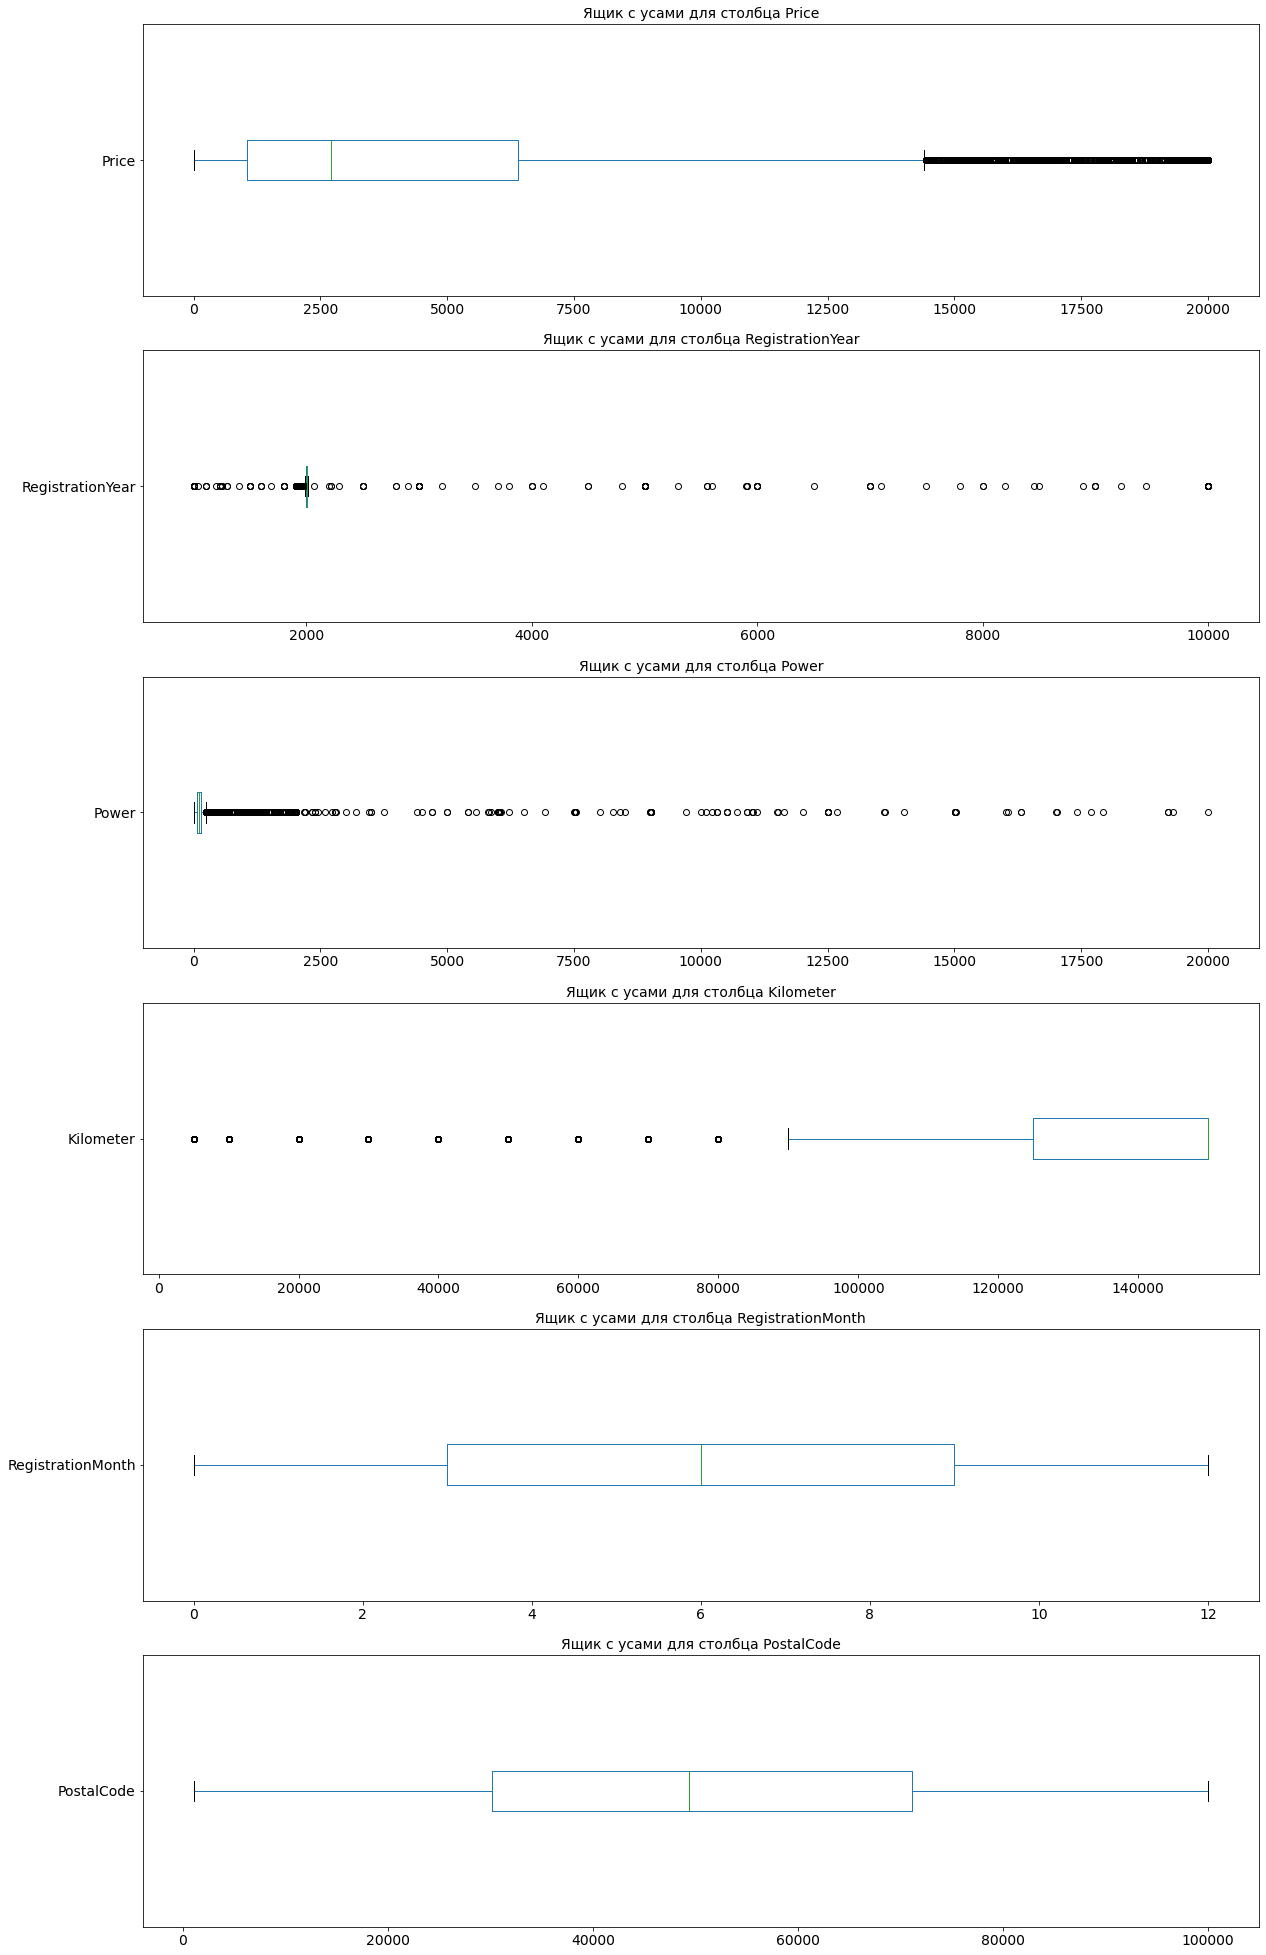

In [14]:
# Создаём переменную в который будет список с количественными значениями autos
cols_to_check = ['Price', 'RegistrationYear', 'Power',
                 'Kilometer', 'RegistrationMonth', 'PostalCode']

fig, axes = plt.subplots(nrows=len(cols_to_check), figsize=(20, 35))

for i, col in enumerate(cols_to_check):
    autos[col].plot(kind='box', vert=False, ax=axes[i], fontsize=14)
    axes[i].set_title(f"Ящик с усами для столбца {col}", fontsize=14)

plt.show()

In [15]:
columns_to_filter = ['Power', 'RegistrationYear', 'Price']

for column in columns_to_filter:
    Q1 = autos[column].quantile(0.25)
    Q3 = autos[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    autos = autos[(autos[column] >= lower_bound) & (autos[column] <= upper_bound)]

#### 2.3 Удаление неинформативных признаков

In [16]:
p = (autos['Price'] == 0).sum()
p

10017

In [17]:
# Удаляем неинформативные признаки
autos = autos.drop(autos[autos['Price'] == 0].index)

In [18]:
# Отбираем объявления, в которых год регистрации меньше, чем год объявления по продаже авто
autos = autos[autos['RegistrationYear'] <= autos['DateCreated'].dt.year]

> **Выводы по второму шагу:**
>
> Во втором шаге были проделаны следующие действия:
>  - поиск явных и неявных дубликатов;
>  - поиск аномальных значений;
>
> **После проведённых действий можно сделать следующие выводы:**
> 1. в датафреймах обнаружены явные дубликаты, которые успешно удалены;
> 2. в процессе поиска аномальных значений выяснилось, что в столбцах с количественными значениями есть выбросы, из столбцов 'Power', 'RegistrationYear', 'Price' были удалены выбросы;
> 3. в данных есть неинформативные данные, которые были удалены.

## 3. Обучение моделей

In [19]:
# Удаление лишних признаков (кроме 'Price')
autos = autos.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen',
                           'RegistrationMonth', 'NumberOfPictures', 'PostalCode'])

# Проверка на наличие дубликатов
duplicates = autos.duplicated()

# Подсчет количества дубликатов
num_duplicates = duplicates.sum()

if num_duplicates > 0:
    print(f"Обнаружено {num_duplicates} дубликатов в данных.")
else:
    print("Дубликатов в данных не обнаружено.")

Обнаружено 39715 дубликатов в данных.


In [20]:
# Удаление дубликатов из данных
autos = autos.drop_duplicates()

# Проверка, что дубликаты успешно удалены
if autos.duplicated().any():
    print("Не удалось удалить все дубликаты.")
else:
    print("Дубликаты успешно удалены.")

Дубликаты успешно удалены.


In [21]:
corr = autos.corr()
corr

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.540099,0.426973,-0.287767
RegistrationYear,0.540099,1.000000,0.084603,-0.286597
Power,0.426973,0.084603,1.000000,0.140709
Kilometer,-0.287767,-0.286597,0.140709,1.000000


In [22]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Разделение данных на признаки (X) и целевую переменную (y)
X = autos.drop(columns=['Price'])
y = autos['Price']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

ohe_columns = ['VehicleType', 'FuelType', 'Brand', 'Model', 'Repaired', 'Gearbox'] 
num_columns = ['Power', 'Kilometer', 'RegistrationYear']  

# Создаем препроцессор
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', StandardScaler(), num_columns)
], remainder='passthrough')

# Создаем DummyRegressor, который будет предсказывать среднее значение тренировочной выборки
dummy_model = DummyRegressor(strategy='mean')

# Создаем модели и их параметры
models_params = [
    (dummy_model, {}),
    (LinearRegression(), {'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}),
    (DecisionTreeRegressor(random_state=RANDOM_STATE), {
        'models__min_samples_split': range(2, 6),
        'models__min_samples_leaf': range(1, 6),
        'models__max_depth': (None, *range(2, 6)),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }),
    (LGBMRegressor(random_state=RANDOM_STATE), {
        'models__n_estimators': [100, 200, 300],
        'models__learning_rate': [0.01, 0.05, 0.1]
    })
]

# Создаем пустой список для хранения результатов
results = []

# Поиск лучших моделей и оценка их производительности
for model, params in models_params:
    # Создаем конвейер для модели
    pipe = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', model)
    ])
    
    # Замеряем время обучения
    start_train = time()
    grid_search = RandomizedSearchCV(pipe, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    end_train = time()
    
    # Получаем лучшую модель и её параметры
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Замеряем время предсказания на обучающей выборке
    start_pred_train = time()
    y_pred_train = best_model.predict(X_train)
    end_pred_train = time()

    # Замеряем время обучения лучшей модели с лучшими параметрами
    start_train_best = time()
    best_model.fit(X_train, y_train)
    end_train_best = time()
    
    # Получаем время предсказания лучшей модели на обучающей выборке
    start_pred_train_best = time()
    y_pred_train_best = best_model.predict(X_train)
    end_pred_train_best = time()
  
    # Рассчитываем RMSE на обучающей выборке
    rmse_train_best = mean_squared_error(y_train, y_pred_train_best, squared=False)
    
    # Сохраняем результаты в список
    results.append({
        'Model': type(model).__name__,
        'Best Params': best_params,
        'Best Score': -grid_search.best_score_,
        'Training Time (min)': (end_train_best - start_train_best) / 60,
        'Prediction Time Train (min)': (end_pred_train_best - start_pred_train_best) / 60,
    })
    
    # Выводим результаты для обучающей выборки
    print(f'Лучшая модель и её параметры для {type(model).__name__} на обучающей выборке: {best_model}')
    print(f'Метрика лучшей модели на обучающей выборке: {-grid_search.best_score_}')
    print(f'Время обучения лучшей модели: {(end_train_best - start_train_best) / 60} мин')
    print(f'Время предсказания на обучающей выборке: {(end_pred_train_best - start_pred_train_best) / 60} мин')

Лучшая модель и её параметры для DummyRegressor на обучающей выборке: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['VehicleType', 'FuelType',
                                                   'Brand', 'Model', 'Repaired',
                                                   'Gearbox']),
                                                 ('num', StandardScaler(),
                                                  ['Power', 'Kilometer',
                            

In [23]:
# Создаем DataFrame из списка результатов
results_df = pd.DataFrame(results)

# Удаляем строки, соответствующие модели DummyRegressor
results_df = results_df[results_df['Model'] != 'DummyRegressor']

# Выводим таблицу с результатами
results_df

,Model,Best Params,Best Score,Training Time (min),Prediction Time Train (min)
1,LinearRegression,{'preprocessor__num': StandardScaler()},1999.217818,0.032936,0.003651
2,DecisionTreeRegressor,"{'preprocessor__num': 'passthrough', 'models__...",1457.927599,0.216968,0.004284
3,LGBMRegressor,"{'models__n_estimators': 300, 'models__learnin...",1297.619367,0.018990,0.017204


#### 3.1 Оцениваем метрику лучшей модели на тестовой выборке

In [24]:
# Получаем лучшую модель и её параметры
best_model = grid_search.best_estimator_

# Оценка качества на тестовой выборке
y_pred_test = best_model.predict(X_test)

# Расчет RMSE на тестовой выборке
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

# Выводим результат для тестовой выборки
print(f'Лучшая модель и её параметры: {best_model}')
print(f'RMSE для лучшей модели на тестовой выборке: {rmse_test}\n')

Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['VehicleType', 'FuelType',
                                                   'Brand', 'Model', 'Repaired',
                                                   'Gearbox']),
                                                 ('num', StandardScaler(),
                                                  ['Power', 'Kilometer',
                                                   'RegistrationYear

> **Выводы по третьему шагу:**
>
> В третьем шаге были проделаны следующие действия:
>  - построен пайплайн;
>  - обучены 3 модели;
>  - создана таблица с данными о времени обучения и предсказания модели и о её качестве.
>
> **После проведённых действий можно сделать следующие выводы:**
>
> Исходя из критериев заказчика, наиболее подходящей моделью является LGBMRegressor. Она имеет наименьшее время обучения и предсказания, а также наилучшее качество предсказания (значение метрики RMSE равно 1253.940120 < 2500).

## 4. Общий вывод

В ходе исследования проекта по определению стоимости автомобилей были выполнены шаги, начиная с загрузки данных и заканчивая анализом моделей. Были проведены предобработка данных, обучение моделей и анализ их результатов. Исходя из критериев заказчика (качество предсказания, время обучения модели и время предсказания модели), мы должны выбрать модель, которая демонстрирует лучшее качество предсказания при разумном времени обучения и предсказания.

Сравнивая результаты тестирования моделей, можно сделать следующие выводы:

> DummyRegressor:
>
> Время обучения: 0.037406 секунд,
> Время предсказания: 0.002517 секунд,
> RMSE: 3267.326240
>
> LinearRegression:
>
> Время обучения: 1.091584 секунд,
> Время предсказания: 0.003384 секунд,
> RMSE: 1942.576061
>
> DecisionTreeRegressor:
>
> Время обучения: 1.345350 секунд,
> Время предсказания: 0.003818 секунд,
> RMSE: 1341.936376
>
> LGBMRegressor:
>
> Время обучения: 0.819303 секунд
> Время предсказания: 0.007252 секунд
> RMSE: 1254.739342

На основе представленных результатов, можно сделать вывод, что модель LGBMRegressor демонстрирует наилучшее качество предсказания (наименьший RMSE) при разумном времени обучения и предсказания. Кроме того, она показывает значительное улучшение по сравнению с константной моделью (DummyRegressor). Следовательно, LGBMRegressor является наилучшим выбором для решения задачи.